In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import datetime
import os
from collections import Counter


In [2]:
pd.set_option('display.max_columns', None)
np.random.seed(4)

### Load the data

In [3]:
data = pd.read_csv("Data/transactions_train.csv", dtype={'article_id':str})
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [4]:
articles = pd.read_csv("Data/articles.csv", dtype={'article_id':str})
customers = pd.read_csv("Data/customers.csv", dtype={'customer_id':str})

In [5]:
customers.shape

(1371980, 7)

In [6]:
print("All Transactions Date Range: {} to {}".format(data['t_dat'].min(), data['t_dat'].max()))

data["t_dat"] = pd.to_datetime(data["t_dat"])

train = data.loc[(data["t_dat"] >= datetime.datetime(2020,8,24)) & (data['t_dat'] < datetime.datetime(2020,9,16))]
val = data.loc[data["t_dat"] >= datetime.datetime(2020,9,16)]

All Transactions Date Range: 2018-09-20 to 2020-09-22


In [7]:
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id
30665422,2020-08-24,0000e9a4db2da4e9c68558ad1e7df570d02767b213ec6b...,0880553001,0.025407,2
30665423,2020-08-24,0000e9a4db2da4e9c68558ad1e7df570d02767b213ec6b...,0880553001,0.025407,2
30665424,2020-08-24,00047d50bde8751b26aaec7536ccc5fd92828ffa0a396d...,0909081004,0.033881,2
30665425,2020-08-24,00047d50bde8751b26aaec7536ccc5fd92828ffa0a396d...,0516903024,0.025407,2
30665426,2020-08-24,00047d50bde8751b26aaec7536ccc5fd92828ffa0a396d...,0897679003,0.042356,2


In [8]:
val.head()

,t_dat,customer_id,article_id,price,sales_channel_id
31548013,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,0786022008,0.048441,2
31548014,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,0913272003,0.032288,2
31548015,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,0889669006,0.056508,2
31548016,2020-09-16,0010e8eb18f131e724d6997909af0808adbba057529edb...,0237347060,0.033881,1
31548017,2020-09-16,0010e8eb18f131e724d6997909af0808adbba057529edb...,0562245001,0.013542,1


In [ ]:
# List of all purchases per user (has repetitions)
positive_items_per_user = train.groupby(['customer_id'])['article_id'].apply(list)

train['pop_factor'] = train['t_dat'].apply(lambda x: 1/(datetime.datetime(2020,9,16) - x).days)
popular_items_group = train.groupby(['article_id'])['pop_factor'].sum()
_, popular_items = zip(*sorted(zip(popular_items_group, popular_items_group.keys()))[::-1])

train['pop_factor'].describe()

/var/folders/18/tt4qk8fx5kj_pq96nkcnfxzh0000gn/T/ipykernel_2487/2363426016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pop_factor'] = train['t_dat'].apply(lambda x: 1/(datetime.datetime(2020,9,16) - x).days)


count    882591.000000
mean          0.145787
std           0.180112
min           0.043478
25%           0.055556
50%           0.083333
75%           0.142857
max           1.000000
Name: pop_factor, dtype: float64

In [10]:
def apk(actual, predicted, k=12):
    '''
    Computes the average precision at k.
    '''
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=12):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [11]:
positive_items_val = val.groupby(['customer_id'])['article_id'].apply(list)

# creating validation set for metrics use case
val_users = positive_items_val.keys()
val_items = []

for i,user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])
    
print("Total users in validation:", len(val_users))

68984it [00:00, 1071613.26it/s]

Total users in validation: 68984


<Axes: xlabel='article_id'>

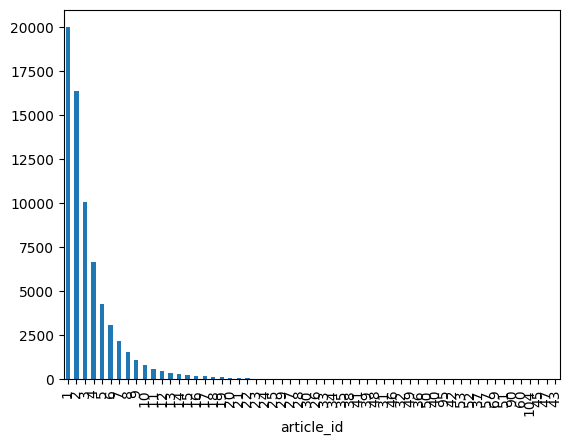

In [34]:
pd.DataFrame(positive_items_val)['article_id'].apply(len).value_counts().plot(kind='bar')

In [12]:
outputs = []
cnt = 0

popular_items = list(popular_items)

for user in tqdm(val_users):
    user_output = []
    if user in positive_items_per_user.keys():
        most_common_items_of_user = {k:v for k, v in Counter(positive_items_per_user[user]).most_common()}
        user_output += list(most_common_items_of_user.keys())
    
    user_output += list(popular_items[:12 - len(user_output)])
    outputs.append(user_output)
    
print("mAP Score on Validation set:", mapk(val_items, outputs))
        
    

100%|██████████| 68984/68984 [00:00<00:00, 90328.55it/s]


mAP Score on Validation set: 0.021837573340948213
